<a href="https://colab.research.google.com/github/tatsuhiko-ikeda3/GAN_with_VIT/blob/main/segan_30epoch_flower_D_se_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=30)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, beta1=0.5, lr_d=0.0003, lr_g=0.0002, n_epoch=30, nch_d=64, nch_g=64, z_dim=100)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform

    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img
    
    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([
    
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),
        
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        
    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        self.q = self.se_block_0(self.q)
        self.k = self.se_block_0(self.k)
        self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        self.q = self.se_block_0(self.q)
        self.k = self.se_block_0(self.k)
        self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
       # out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()
         

    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z) 
        z = self.relu(z)

        z = self.conv2(z) 
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 \n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels) \n        self.bn =

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x 
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding 
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding \n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.se_block_1(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity
        

        identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        #x = self.se_block_1(x)
        x = x + self.shortcut(identity)
        x = self.bn(x)
        
        return x 

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels 
        
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )
        

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True)) 
        if se:
            layers.append(SE_G(out_channels)) 
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))
        


        net = nn.Sequential(*layers)#listのアンパック

        return net
    
    def forward(self, x):      
        out = self.convt1(x)

        out = self.convt2(out)       

        out = self.convt3(out)
      
        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)

        
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = True):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))

       
        net = nn.Sequential(*layers)#listのアンパック
       
        return net
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)    

        out = self.conv3(out)
      
        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:01<00:00,  1.69it/s]


epoch: 0, lossD:0.8553621945631447, lossG:12.21460058619675,lossG_fake:8.51337193053903, lossG_real:3.7012286487134913 ,equality:4.812143281825539


/usr/local/lib/python3.7/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


evaluate:164.107666015625,kid_mean:0.09739399701356888, kid_std:0.022804580628871918,kid_:(tensor(0.0974), tensor(0.0228))


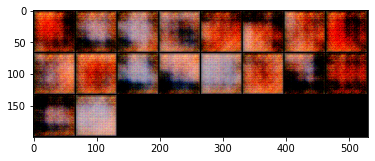

100%|██████████| 103/103 [00:22<00:00,  4.48it/s]


epoch: 1, lossD:0.9539224317170751, lossG:6.472974980919107,lossG_fake:3.802136611012579, lossG_real:2.6708383814802445 ,equality:1.1312982295323346


evaluate:162.63197326660156,kid_mean:0.1259860247373581, kid_std:0.03882642835378647,kid_:(tensor(0.1260), tensor(0.0388))


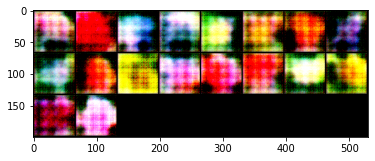

100%|██████████| 103/103 [00:23<00:00,  4.44it/s]


epoch: 2, lossD:1.0007830819169294, lossG:5.943863715940309,lossG_fake:3.530002317382294, lossG_real:2.4138614002940724 ,equality:1.1161409170882215


evaluate:173.6146240234375,kid_mean:0.1373034566640854, kid_std:0.038252461701631546,kid_:(tensor(0.1373), tensor(0.0383))


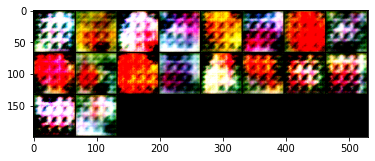

100%|██████████| 103/103 [00:23<00:00,  4.40it/s]


epoch: 3, lossD:1.0420303927752579, lossG:5.865357491576556,lossG_fake:3.5062656414161606, lossG_real:2.3590918628914843 ,equality:1.1471737785246763


evaluate:156.32717895507812,kid_mean:0.11452982574701309, kid_std:0.04599848762154579,kid_:(tensor(0.1145), tensor(0.0460))


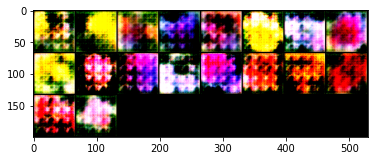

100%|██████████| 103/103 [00:23<00:00,  4.38it/s]


epoch: 4, lossD:0.898538614505703, lossG:6.256605814961554,lossG_fake:3.7341681672531424, lossG_real:2.522437653784613 ,equality:1.2117305134685292


evaluate:138.42251586914062,kid_mean:0.09916340559720993, kid_std:0.04399362951517105,kid_:(tensor(0.0992), tensor(0.0440))


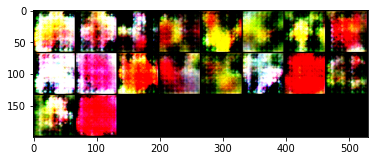

100%|██████████| 103/103 [00:23<00:00,  4.36it/s]


epoch: 5, lossD:0.947416297151047, lossG:6.073574357819789,lossG_fake:3.686032478091786, lossG_real:2.3875418797280026 ,equality:1.2984905983637836


evaluate:137.495849609375,kid_mean:0.10092456638813019, kid_std:0.04665980488061905,kid_:(tensor(0.1009), tensor(0.0467))


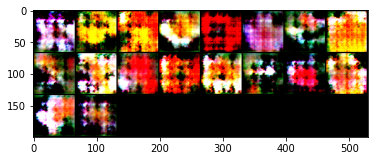

100%|██████████| 103/103 [00:23<00:00,  4.30it/s]


epoch: 6, lossD:1.0250305275893905, lossG:5.907119950044502,lossG_fake:3.5535217326821633, lossG_real:2.3535982138902236 ,equality:1.1999235187919397


evaluate:141.12457275390625,kid_mean:0.09973784536123276, kid_std:0.041334155946969986,kid_:(tensor(0.0997), tensor(0.0413))


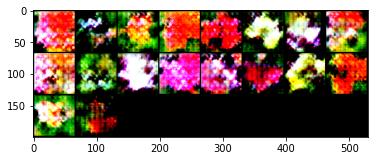

100%|██████████| 103/103 [00:23<00:00,  4.31it/s]


epoch: 7, lossD:0.9059134701501976, lossG:6.10513852406474,lossG_fake:3.6460428920764367, lossG_real:2.4590956343030466 ,equality:1.1869472577733902


evaluate:138.5159912109375,kid_mean:0.09254257380962372, kid_std:0.044774625450372696,kid_:(tensor(0.0925), tensor(0.0448))


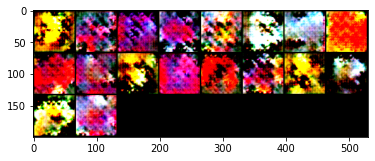

100%|██████████| 103/103 [00:25<00:00,  4.02it/s]


epoch: 8, lossD:0.9854309613843566, lossG:5.709034165132393,lossG_fake:3.3531058737375203, lossG_real:2.3559283104915063 ,equality:0.997177563246014


evaluate:138.33921813964844,kid_mean:0.0952090471982956, kid_std:0.04456355422735214,kid_:(tensor(0.0952), tensor(0.0446))


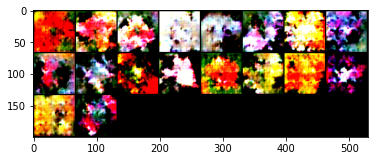

100%|██████████| 103/103 [00:23<00:00,  4.30it/s]


epoch: 9, lossD:1.0007768915694895, lossG:5.491555954646138,lossG_fake:3.1331519096800426, lossG_real:2.358404040336609 ,equality:0.7747478693434338


evaluate:129.38626098632812,kid_mean:0.08888500928878784, kid_std:0.04389205947518349,kid_:(tensor(0.0889), tensor(0.0439))


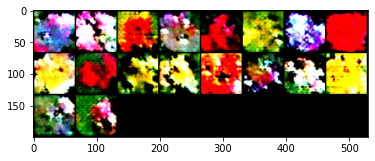

100%|██████████| 103/103 [00:23<00:00,  4.30it/s]


epoch: 10, lossD:1.030318657171379, lossG:5.361138931755881,lossG_fake:3.0397914069370158, lossG_real:2.3213475387073257 ,equality:0.7184438682296901


evaluate:119.74340057373047,kid_mean:0.09057437628507614, kid_std:0.039649609476327896,kid_:(tensor(0.0906), tensor(0.0396))


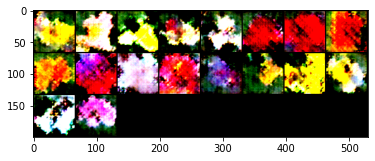

100%|██████████| 103/103 [00:24<00:00,  4.29it/s]


epoch: 11, lossD:1.0519628481378833, lossG:5.158593335197967,lossG_fake:2.8722052307962214, lossG_real:2.286388069101908 ,equality:0.5858171616943135


evaluate:116.69146728515625,kid_mean:0.07912380993366241, kid_std:0.04196538031101227,kid_:(tensor(0.0791), tensor(0.0420))


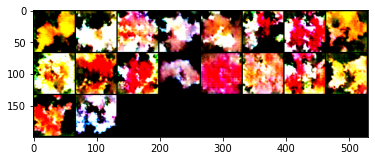

100%|██████████| 103/103 [00:25<00:00,  3.98it/s]


epoch: 12, lossD:1.028751919425807, lossG:5.15185763997939,lossG_fake:2.8451539735192233, lossG_real:2.3067036444701037 ,equality:0.5384503290491196


evaluate:113.2472915649414,kid_mean:0.07679630070924759, kid_std:0.038626402616500854,kid_:(tensor(0.0768), tensor(0.0386))


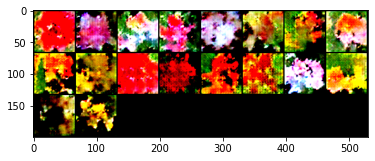

100%|██████████| 103/103 [00:24<00:00,  4.24it/s]


epoch: 13, lossD:0.9997972640597704, lossG:5.179314631860233,lossG_fake:2.867935113536501, lossG_real:2.311379537999051 ,equality:0.55655557553745


evaluate:110.6657943725586,kid_mean:0.07642697542905807, kid_std:0.03888356685638428,kid_:(tensor(0.0764), tensor(0.0389))


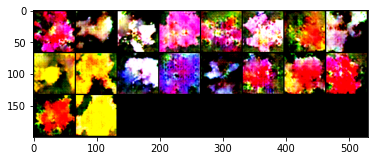

100%|██████████| 103/103 [00:24<00:00,  4.25it/s]


epoch: 14, lossD:1.026955832844799, lossG:5.182897827000294,lossG_fake:2.867194774081406, lossG_real:2.3157030500254585 ,equality:0.5514917240559476


evaluate:110.206298828125,kid_mean:0.08046331256628036, kid_std:0.042166244238615036,kid_:(tensor(0.0805), tensor(0.0422))


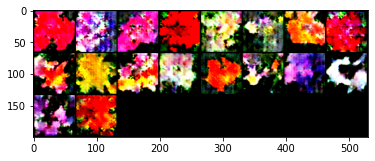

100%|██████████| 103/103 [00:24<00:00,  4.26it/s]


epoch: 15, lossD:0.9748224020004272, lossG:5.183190128178272,lossG_fake:2.841500781114819, lossG_real:2.3416893748403753 ,equality:0.49981140627444365


evaluate:108.06290435791016,kid_mean:0.07748410850763321, kid_std:0.04150407388806343,kid_:(tensor(0.0775), tensor(0.0415))


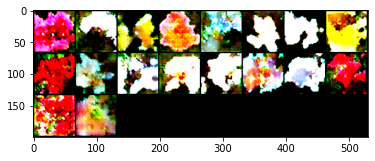

100%|██████████| 103/103 [00:25<00:00,  3.98it/s]


epoch: 16, lossD:0.9980344801273161, lossG:5.326652864808017,lossG_fake:2.9559770915114765, lossG_real:2.3706757825555154 ,equality:0.5853013089559611


evaluate:108.7326431274414,kid_mean:0.07303248345851898, kid_std:0.03999333456158638,kid_:(tensor(0.0730), tensor(0.0400))


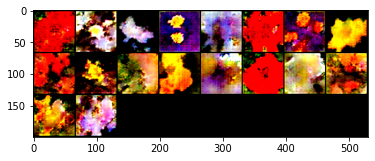

100%|██████████| 103/103 [00:24<00:00,  4.22it/s]


epoch: 17, lossD:0.9477307180177819, lossG:5.2638760770408854,lossG_fake:2.8784813221218517, lossG_real:2.385394767650123 ,equality:0.4930865544717289


evaluate:109.51283264160156,kid_mean:0.07520399242639542, kid_std:0.04160552844405174,kid_:(tensor(0.0752), tensor(0.0416))


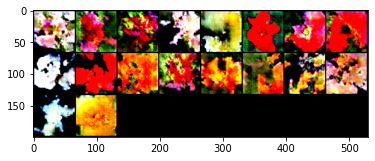

100%|██████████| 103/103 [00:24<00:00,  4.24it/s]


epoch: 18, lossD:0.9130716526392594, lossG:5.448111177648156,lossG_fake:2.9718174717380004, lossG_real:2.4762937212453306 ,equality:0.4955237504926697


evaluate:108.2492904663086,kid_mean:0.07067442685365677, kid_std:0.04296159744262695,kid_:(tensor(0.0707), tensor(0.0430))


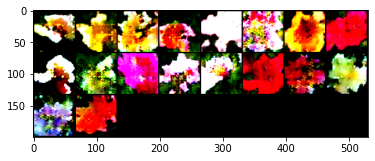

100%|██████████| 103/103 [00:24<00:00,  4.22it/s]


epoch: 19, lossD:0.8631431121849319, lossG:5.4818204953832534,lossG_fake:2.9739558025471213, lossG_real:2.5078646725821265 ,equality:0.4660911299649948


evaluate:107.75706481933594,kid_mean:0.08199494332075119, kid_std:0.04351331293582916,kid_:(tensor(0.0820), tensor(0.0435))


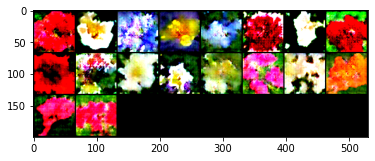

100%|██████████| 103/103 [00:26<00:00,  3.95it/s]


epoch: 20, lossD:0.8444357450725963, lossG:5.64065257322441,lossG_fake:3.0367586485390525, lossG_real:2.6038938934363207 ,equality:0.4328647551027318


evaluate:109.90803527832031,kid_mean:0.07671009749174118, kid_std:0.045762572437524796,kid_:(tensor(0.0767), tensor(0.0458))


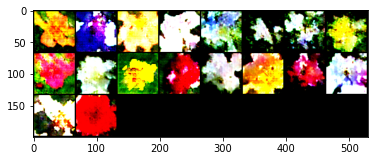

100%|██████████| 103/103 [00:24<00:00,  4.20it/s]


epoch: 21, lossD:0.874315515883918, lossG:5.65908418118375,lossG_fake:3.0574825764859765, lossG_real:2.6016015965961716 ,equality:0.4558809798898049


evaluate:111.22797393798828,kid_mean:0.06852193176746368, kid_std:0.03564197197556496,kid_:(tensor(0.0685), tensor(0.0356))


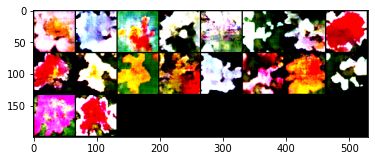

100%|██████████| 103/103 [00:24<00:00,  4.15it/s]


epoch: 22, lossD:0.7372638886993371, lossG:5.8499347862688085,lossG_fake:3.119805316033873, lossG_real:2.7301294890422265 ,equality:0.38967582699164627


evaluate:111.90474700927734,kid_mean:0.07053007185459137, kid_std:0.037090204656124115,kid_:(tensor(0.0705), tensor(0.0371))


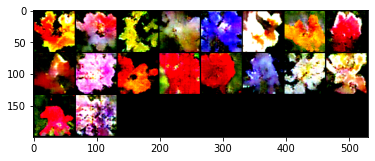

100%|██████████| 103/103 [00:24<00:00,  4.15it/s]


epoch: 23, lossD:0.6612145356038241, lossG:5.883690764603106,lossG_fake:3.1073574580035164, lossG_real:2.77633332048805 ,equality:0.33102413751546633


evaluate:111.17655944824219,kid_mean:0.08488151431083679, kid_std:0.047271281480789185,kid_:(tensor(0.0849), tensor(0.0473))


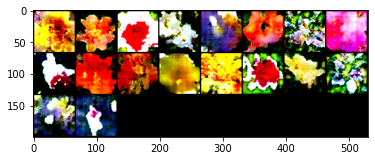

100%|██████████| 103/103 [00:25<00:00,  4.10it/s]


epoch: 24, lossD:0.6967668647615655, lossG:6.154899055517993,lossG_fake:3.3258793076265207, lossG_real:2.8290197519422735 ,equality:0.4968595556842472


evaluate:111.24373626708984,kid_mean:0.08188311755657196, kid_std:0.04355291277170181,kid_:(tensor(0.0819), tensor(0.0436))


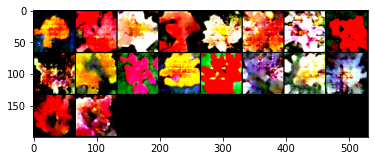

100%|██████████| 103/103 [00:25<00:00,  4.11it/s]


epoch: 25, lossD:0.614537446822935, lossG:6.2303236433603235,lossG_fake:3.306933062747844, lossG_real:2.9233906037599136 ,equality:0.3835424589879306


evaluate:111.24281311035156,kid_mean:0.08380358666181564, kid_std:0.04669025167822838,kid_:(tensor(0.0838), tensor(0.0467))


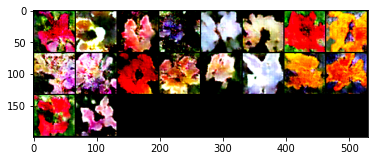

100%|██████████| 103/103 [00:25<00:00,  4.10it/s]


epoch: 26, lossD:0.49934921142401045, lossG:6.32565037718097,lossG_fake:3.3785050204656657, lossG_real:2.947145353243189 ,equality:0.4313596672224769


evaluate:111.90690612792969,kid_mean:0.07892100512981415, kid_std:0.045396942645311356,kid_:(tensor(0.0789), tensor(0.0454))


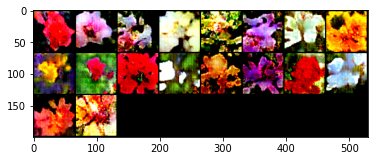

100%|██████████| 103/103 [00:25<00:00,  4.06it/s]


epoch: 27, lossD:0.5472108468558025, lossG:6.447975982740087,lossG_fake:3.440532671595083, lossG_real:3.0074433018860307 ,equality:0.4330893697090521


evaluate:111.18524169921875,kid_mean:0.0746266096830368, kid_std:0.038803309202194214,kid_:(tensor(0.0746), tensor(0.0388))


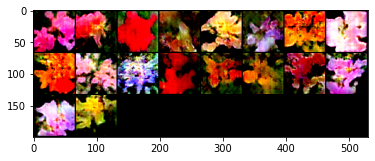

100%|██████████| 103/103 [00:25<00:00,  4.06it/s]


epoch: 28, lossD:0.4694701905714945, lossG:6.5369817955980025,lossG_fake:3.518204292047371, lossG_real:3.018777505865375 ,equality:0.4994267861819961


evaluate:112.12245178222656,kid_mean:0.07116013020277023, kid_std:0.03807010501623154,kid_:(tensor(0.0712), tensor(0.0381))


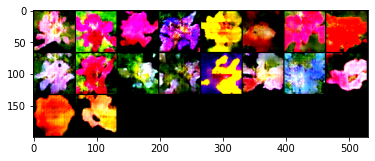

100%|██████████| 103/103 [00:25<00:00,  4.03it/s]


epoch: 29, lossD:0.5023486718390752, lossG:6.741292972009159,lossG_fake:3.6134814614231145, lossG_real:3.1278114793370073 ,equality:0.48566998208610723


evaluate:111.65870666503906,kid_mean:0.07641024887561798, kid_std:0.04036137834191322,kid_:(tensor(0.0764), tensor(0.0404))


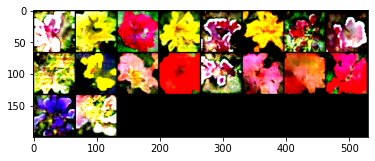

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality 
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))
        

        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()
        
        #train generator
        
        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake    


        lossG.backward()
        optimizerG.step()
        
        # save loss
        
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()


        
    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()

    
  
    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

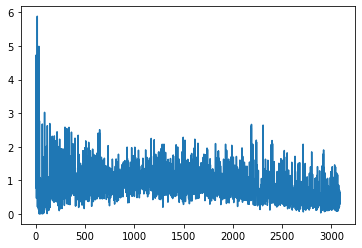

In [45]:
plt.plot(raw_lossesD)

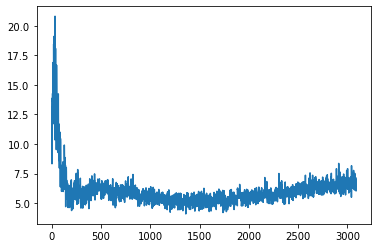

In [46]:
plt.plot(raw_lossesG)

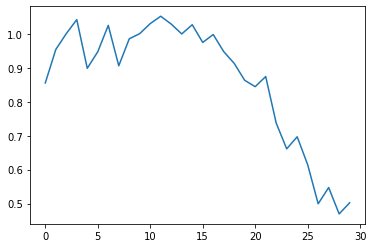

In [47]:
plt.plot(lossesD)

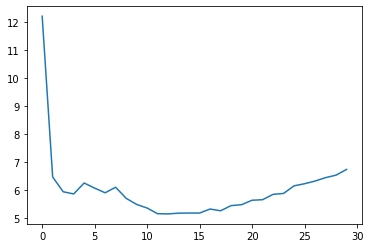

In [48]:
plt.plot(lossesG)

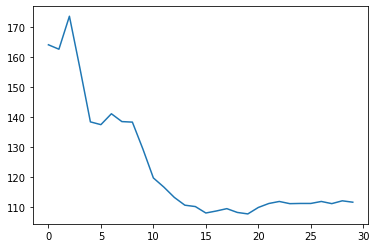

In [49]:
plt.plot(fid_)

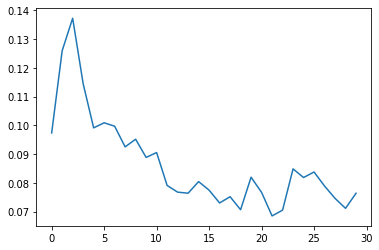

In [50]:
plt.plot(kid_mean_)

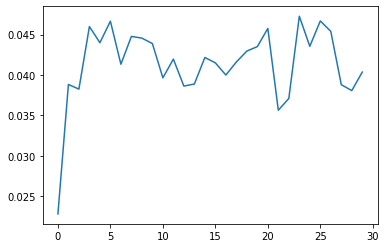

In [51]:
plt.plot(kid_std_)

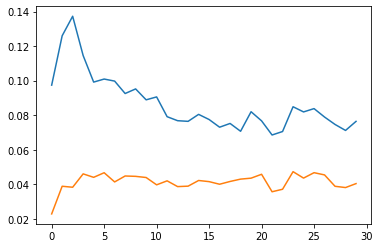

In [52]:
plt.plot(kid_score)

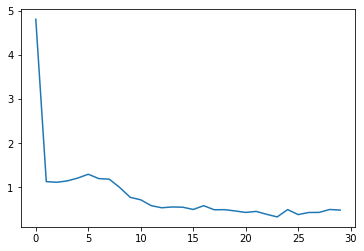

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0760), tensor(0.0428))